# Problem Statement

The problem statement revolves around predicting daily sales for multiple stores based on historical sales data, promotions, and other factors

# Data Overview:

The data has been taken from Walmart Recruiting challenge on kaggle. Data Field contains a total of 4 datasets:

**stores.csv**

This file contains anonymized information about the 45 stores, indicating the type and size of the store.


Store: the store number\
Types: Types of the store\
Size: the size of the store

**train.csv**

This is the historical training data, which covers 2010–02–05 to 2012–11–01. Within this file you will find the following fields:


Store: the store number\
Dept: the department number\
Date : the dates of sales\
Weekly_Sales : sales for the given department in the given store\
IsHoliday : whether the week is a special holiday week

**test.csv**

This file is similar to train file, except weekly sales

**features.csv**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

Store: the store number\
Date: the week\
Temperature: the average temperature in the region\
Fuel_Price: the cost of fuel in the region\
MarkDown1–5: anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA.
CPI: the consumer price index\
Unemployment: the unemployment rate\
IsHoliday: whether the week is a special holiday week

# 1. Import Libraries

In [1]:
#load required libraries

import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold,cross_val_score

C:\Users\KESHAV\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 2. Load and Read the dataset

In [2]:
# Load dataset
df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
print(df.head())
print(df.info())
print(features_df.head())
print(features_df.info())
print(stores_df.head())
print(stores_df.info())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548      

In [3]:
# Join feature dataset with train data
features_df = pd.read_csv('features.csv')
df = pd.merge(df, features_df.drop(['IsHoliday'], axis = 1), how = 'left', on = ['Store', 'Date'])

In [4]:
df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106


In [5]:
# Join store dataset with above data
stores_df = pd.read_csv('stores.csv')
master_df = pd.merge(df, stores_df, how = 'left', on = ['Store'])

In [6]:
master_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


# 2. Overview of the Dataset 

Get an overview by examining the dimensions of the dataset, the types of data in each column, and checking for missing values.\
Dimensions: The number of rows and columns.\
Data Types: The type of data in each column.\
Missing Values: Check for any missing data.

In [7]:
# Basic information about the dataset
data_info = {
    "Number of Rows": master_df.shape[0],
    "Number of Columns": master_df.shape[1],
    "Column Names": master_df.columns.tolist(),
    "Data Types": master_df.dtypes,
}

data_info

{'Number of Rows': 421570,
 'Number of Columns': 16,
 'Column Names': ['Store',
  'Dept',
  'Date',
  'Weekly_Sales',
  'IsHoliday',
  'Temperature',
  'Fuel_Price',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment',
  'Type',
  'Size'],
 'Data Types': Store             int64
 Dept              int64
 Date             object
 Weekly_Sales    float64
 IsHoliday          bool
 Temperature     float64
 Fuel_Price      float64
 MarkDown1       float64
 MarkDown2       float64
 MarkDown3       float64
 MarkDown4       float64
 MarkDown5       float64
 CPI             float64
 Unemployment    float64
 Type             object
 Size              int64
 dtype: object}

This dataset has 16 features, with a mix of categorical and numerical features.

# 3.Data Cleaning and Preparation

In [8]:
#Identify how much data is missing
df_missing = pd.DataFrame({ 'Missing Values': master_df.isnull().sum().sort_values(ascending=False),
                            'Missing Percent': (master_df.isnull().sum().sort_values(ascending=False) / master_df.shape[0]) * 100 })
df_missing

,Missing Values,Missing Percent
MarkDown2,310322,73.611025
MarkDown4,286603,67.984676
MarkDown3,284479,67.480845
MarkDown1,270889,64.257181
MarkDown5,270138,64.079038
Store,0,0.000000
Dept,0,0.000000
Date,0,0.000000
Weekly_Sales,0,0.000000
IsHoliday,0,0.000000


We see that features MarkDown 1-5, contains null values

**Check for Duplicate Values**

In [9]:
# Are there any duplicates?
dups = master_df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
master_df[dups]

Number of duplicate rows = 0


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size


We see that, there is no duplicate values

In [10]:
# Convert Date column tp datetime
master_df['Date'] = pd.to_datetime(master_df['Date'])

# 4.Exploratory data analysis

**Summary statistics of the dataset**

In [11]:
master_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,421570.0,22.200546,1.0,11.0,22.0,33.0,45.0,12.785297
Dept,421570.0,44.260317,1.0,18.0,37.0,74.0,99.0,30.492054
Date,421570,2011-06-18 08:30:31.963375104,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,421570.0,15981.258123,-4988.94,2079.65,7612.03,20205.8525,693099.36,22711.183519
Temperature,421570.0,60.090059,-2.06,46.68,62.09,74.28,100.14,18.447931
Fuel_Price,421570.0,3.361027,2.472,2.933,3.452,3.738,4.468,0.458515
MarkDown1,150681.0,7246.420196,0.27,2240.27,5347.45,9210.9,88646.76,8291.221345
MarkDown2,111248.0,3334.628621,-265.76,41.6,192.0,1926.94,104519.54,9475.357325
MarkDown3,137091.0,1439.421384,-29.1,5.08,24.6,103.99,141630.61,9623.07829
MarkDown4,134967.0,3383.168256,0.22,504.22,1481.31,3595.04,67474.85,6292.384031


the average weekly sales are 16K, the average CPI is 171, and the average size of the store is 136728.Note the minimum value of weekly sales -4,989, which might indicate returns or data errors.

In [12]:
# Descriptive statistics for category variables
master_df.describe(include='object').T

,count,unique,top,freq
Type,421570,3,A,215478


**1. Pie Visualisation for store types**

  Type  Store
0    A     22
1    B     17
2    C      6


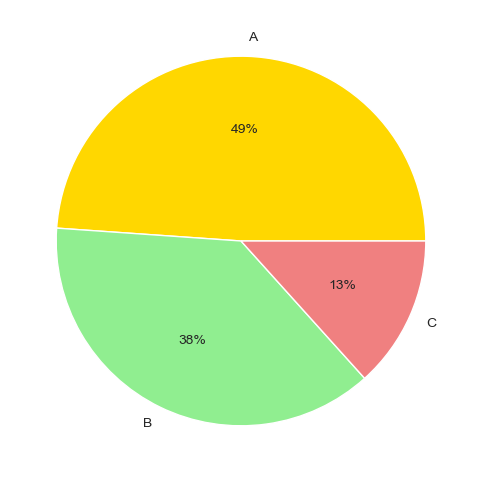

In [13]:
# Setting the aesthetic style of the plots
sns.set_style('whitegrid')

store_by_type = pd.DataFrame(master_df.groupby('Type')['Store'].nunique()).reset_index()
print(store_by_type)

# Plotting the trends
plt.figure(figsize=(12, 6))

plt.pie(store_by_type['Store'], labels = store_by_type['Type'], autopct = '%.0f%%', colors=['gold', 'lightgreen', 'lightcoral'])
plt.show()

There are a total of 3 store types among 45 stres. Store type A having a share of 49% of total stores, B having a share of 38% of total stores, and C having a share of 13% of total stores.

**2.Size distribution of stores for each store type**

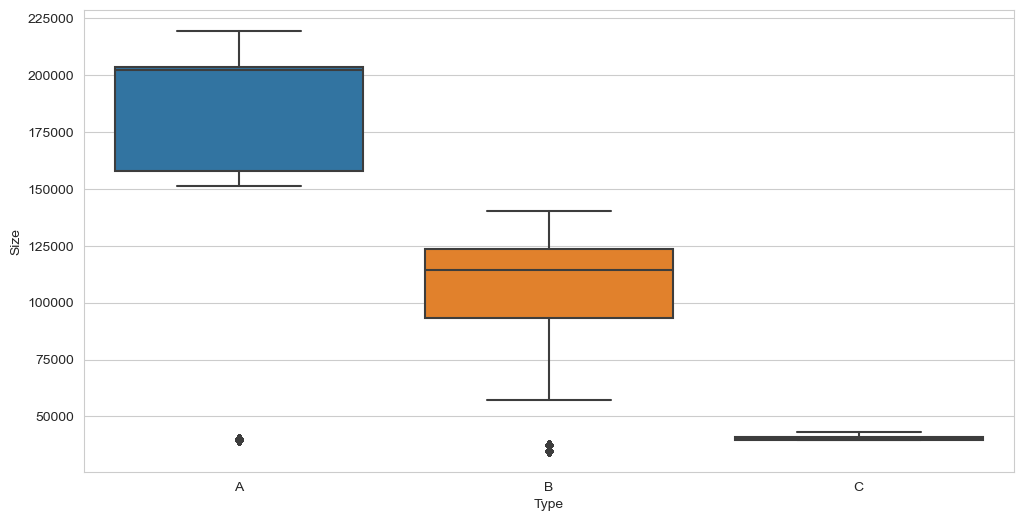

In [14]:
# size distribution of stores for each store type
store_type = pd.concat([master_df['Type'], master_df['Size']], axis=1)

plt.figure(figsize = (12,6))

sns.boxplot(x = 'Type', y ='Size', data = store_type)
plt.show()

Store type A are the largest ones in terms of size, store type B are smaller than A, and store type C are the smallest ones.

**3.Distribution of weekly sales for each store type**

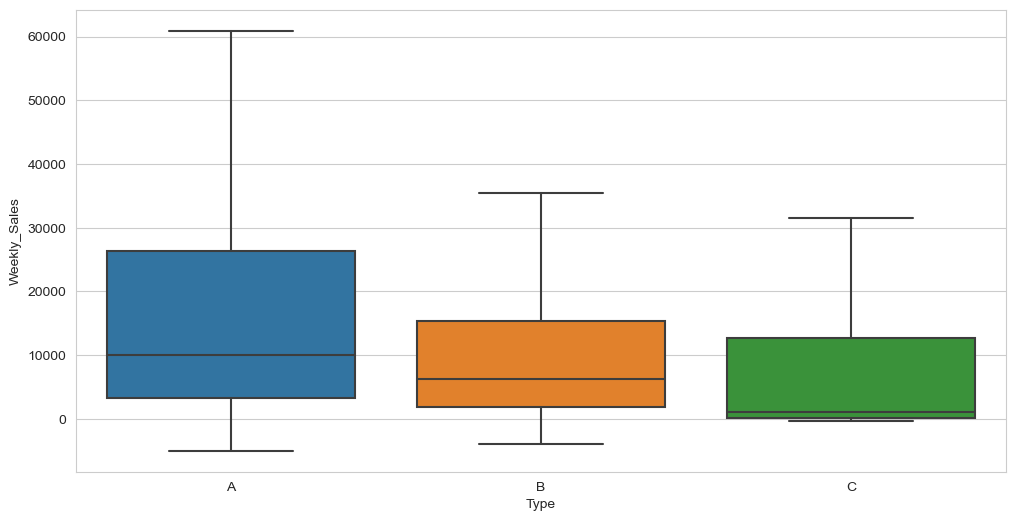

In [15]:
# distribution of weekly sales for each store type
sales_by_type = pd.concat([master_df['Type'], master_df['Weekly_Sales']], axis=1)

plt.figure(figsize = (12,6))

sns.boxplot(x = 'Type', y ='Weekly_Sales', data = sales_by_type, showfliers=False)
plt.show()

weekly sales are on the higher side for A compared with B and C.

**4.What is the impact of holidays on weekly sales**

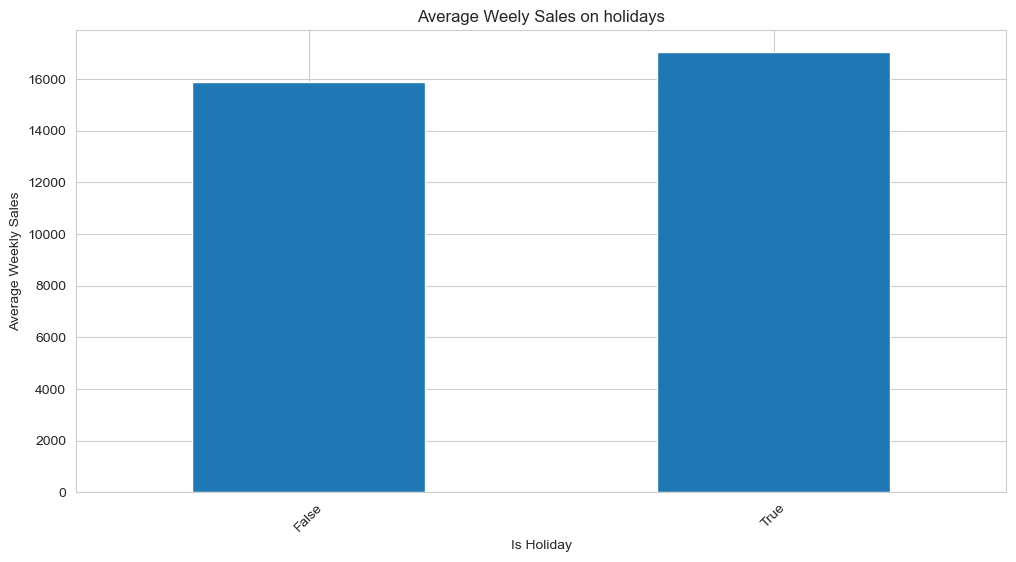

Average Weely Sales on holidays:  IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64


In [16]:
sales_holiday = master_df.groupby('IsHoliday')['Weekly_Sales'].mean()

#Creating a bar chart for average sales on holidays
sales_holiday.plot(kind='bar',figsize=(12,6))
plt.title('Average Weely Sales on holidays')
plt.ylabel('Average Weekly Sales')
plt.xlabel('Is Holiday')
plt.xticks(rotation=45)
plt.show()

print('Average Weely Sales on holidays: ',sales_holiday)

we observe that there is no major impact observed of holidays on weekly sales figures.

**5.Which store has the maximum sales**

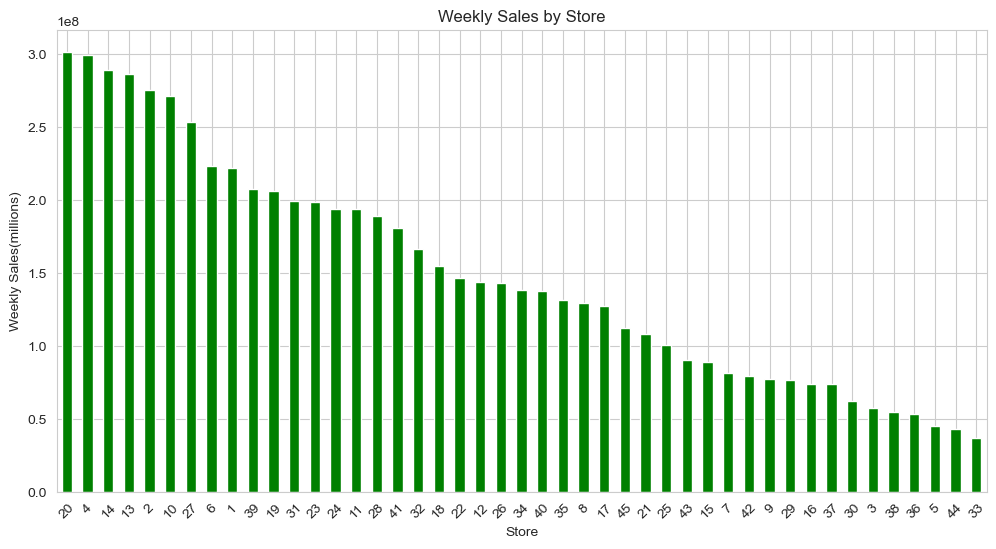

weekly sales by store:  Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
19    2.066349e+08
31    1.996139e+08
23    1.987506e+08
24    1.940160e+08
11    1.939628e+08
28    1.892637e+08
41    1.813419e+08
32    1.668192e+08
18    1.551147e+08
22    1.470756e+08
12    1.442872e+08
26    1.434164e+08
34    1.382498e+08
40    1.378703e+08
35    1.315207e+08
8     1.299512e+08
17    1.277821e+08
45    1.123953e+08
21    1.081179e+08
25    1.010612e+08
43    9.056544e+07
15    8.913368e+07
7     8.159828e+07
42    7.956575e+07
9     7.778922e+07
29    7.714155e+07
16    7.425243e+07
37    7.420274e+07
30    6.271689e+07
3     5.758674e+07
38    5.515963e+07
36    5.341221e+07
5     4.547569e+07
44    4.329309e+07
33    3.716022e+07
Name: Weekly_Sales, dtype: float64


In [17]:
sales_by_store = master_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

#Creating a bar chart for sales by store
sales_by_store.plot(kind='bar',figsize=(12,6), color='green' )
plt.title('Weekly Sales by Store')
plt.ylabel('Weekly Sales(millions)')
plt.xlabel('Store')
plt.xticks(rotation=45)
plt.show()

print('weekly sales by store: ',sales_by_store)

Store 20 Leading with the highest weekly sales, approximately 3 million.

Following Store 20, store 4 and 14 also exhibit high weekly sales but slightly less than Store 20.

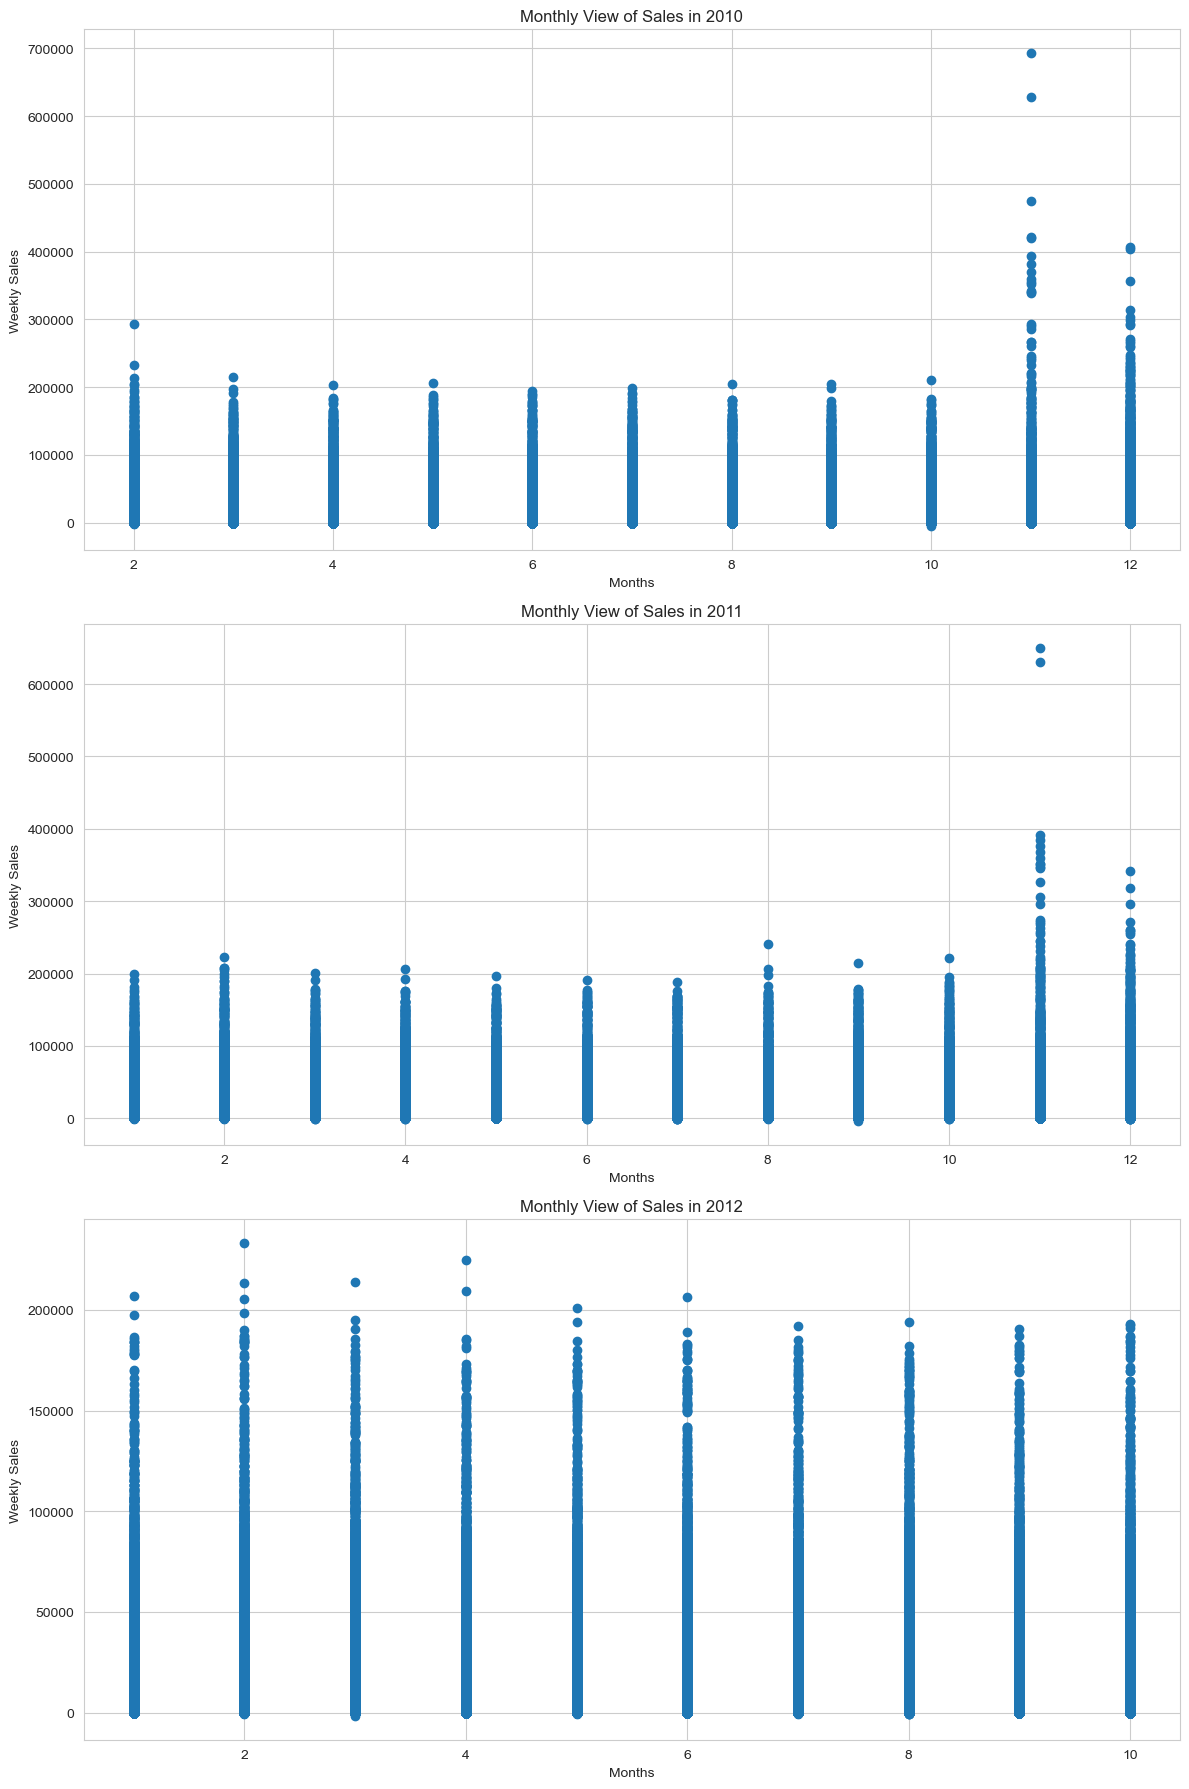

In [18]:
# Monthly view of sales for each years
plt.figure(figsize=(12, 18))

# First subplot for 2010 
plt.subplot(3, 1, 1) 
plt.scatter(master_df[master_df['Date'].dt.year == 2010]['Date'].dt.month, master_df[master_df['Date'].dt.year == 2010]["Weekly_Sales"]) 
plt.xlabel("Months") 
plt.ylabel("Weekly Sales") 
plt.title("Monthly View of Sales in 2010") 

# Second subplot for 2011 
plt.subplot(3, 1, 2) 
plt.scatter(master_df[master_df['Date'].dt.year == 2011]['Date'].dt.month, master_df[master_df['Date'].dt.year == 2011]["Weekly_Sales"]) 
plt.xlabel("Months") 
plt.ylabel("Weekly Sales") 
plt.title("Monthly View of Sales in 2011") 

# Third subplot for 2012 
plt.subplot(3, 1, 3) 
plt.scatter(master_df[master_df['Date'].dt.year == 2012]['Date'].dt.month, master_df[master_df['Date'].dt.year == 2012]["Weekly_Sales"]) 
plt.xlabel("Months") 
plt.ylabel("Weekly Sales") 
plt.title("Monthly View of Sales in 2012") 

plt.tight_layout() 
plt.show()

Both 2010 and 2011 show clear spikes in sales during December, highlighting the impact of the holiday season on weekly sales.

While 2010 and 2011 have similar sales patterns, 2012 deviates, suggesting a shift in factors influencing sales.

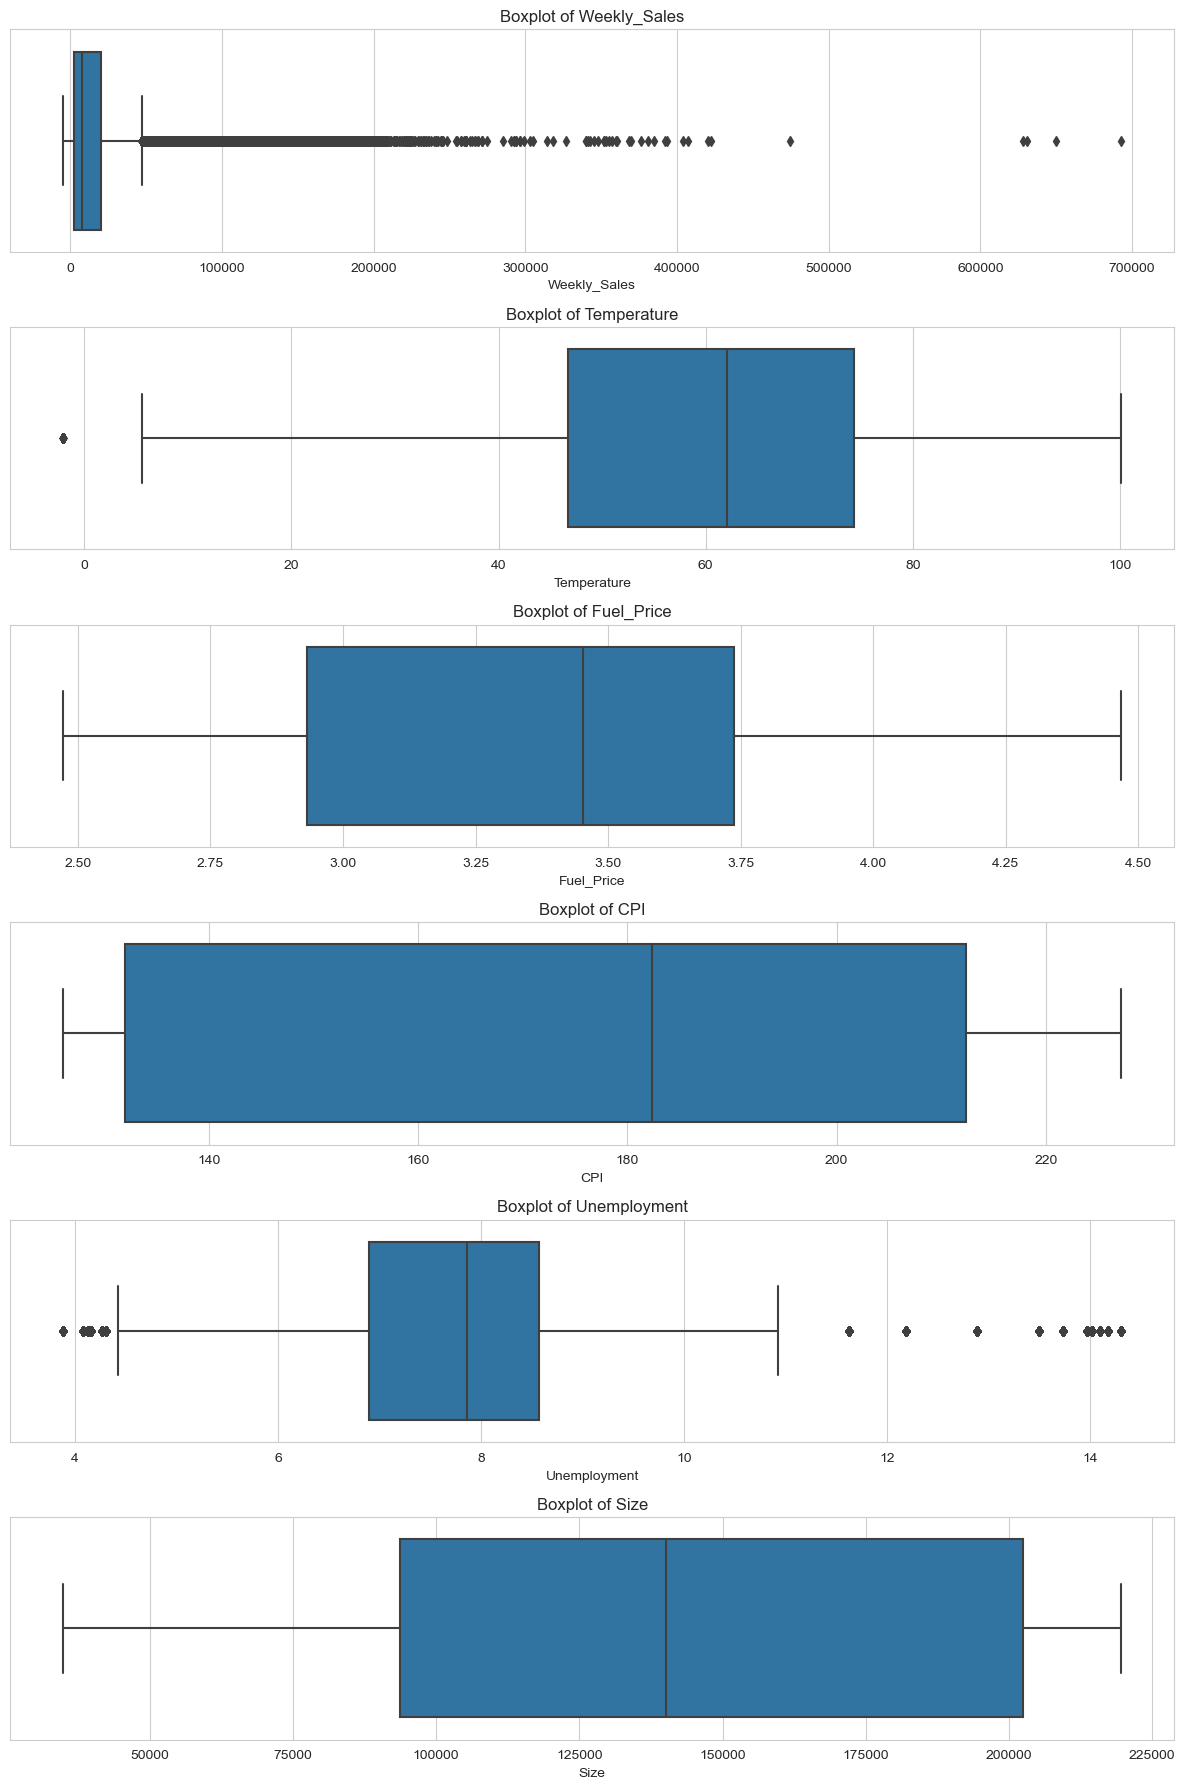

In [19]:
# find outliers 
fig, axs = plt.subplots(6, 1, figsize=(12, 18))
# List of columns to plot 
X = master_df[['Weekly_Sales','Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']]
# Plot each column in a separate subplot 
for i, column in enumerate(X): 
    sns.boxplot(x=master_df[column], ax=axs[i]) 
    axs[i].set_title(f'Boxplot of {column}') 
    axs[i].set_xlabel(column)
    
plt.tight_layout() 
plt.show()

We have outliers in Temperature column and Unemployment

In [20]:
# Function to detect outliers using IQR method
def iqr_method_outliers(column):
    data_ = column
    q1 = data_.quantile(.25)
    q3 = data_.quantile(.75)
    iqr = q3-q1
    lower_bound = q1 - 1.25*iqr
    upper_bound = q3 + 1.25*iqr
    return data_.clip(lower=lower_bound, upper=upper_bound, axis=0)

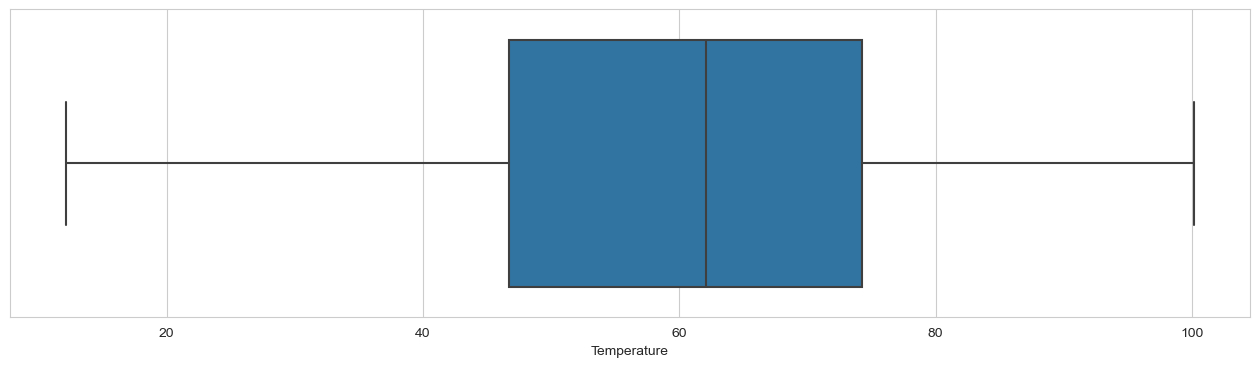

In [21]:
# Check outliners of Temperature
plt.figure(figsize=(16, 4))
sns.boxplot(x=iqr_method_outliers(master_df['Temperature']))
plt.show()

In [22]:
master_df['Temperature'] = iqr_method_outliers(column=master_df['Temperature'])

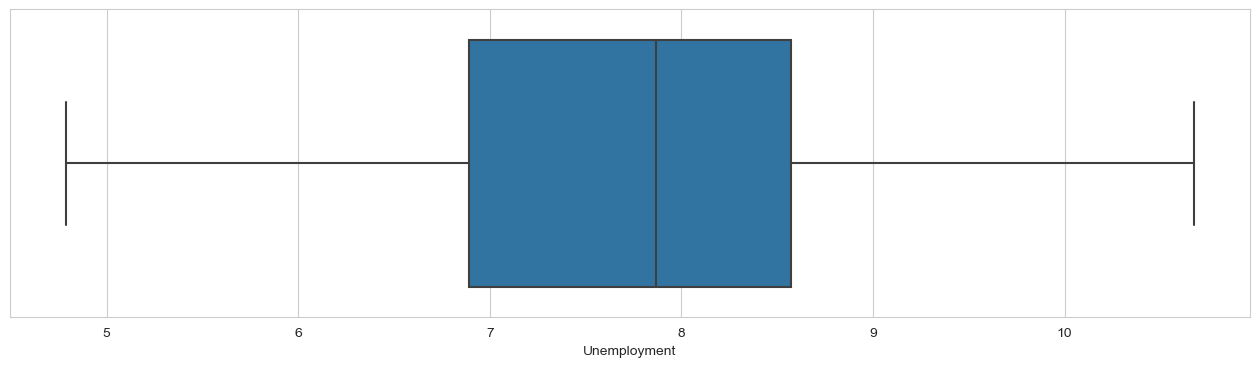

In [23]:
# Check outliners of Unemployment
plt.figure(figsize=(16, 4))
sns.boxplot(x=iqr_method_outliers(master_df['Unemployment']))
plt.show()

In [24]:
master_df['Unemployment'] = iqr_method_outliers(column=master_df['Unemployment'])

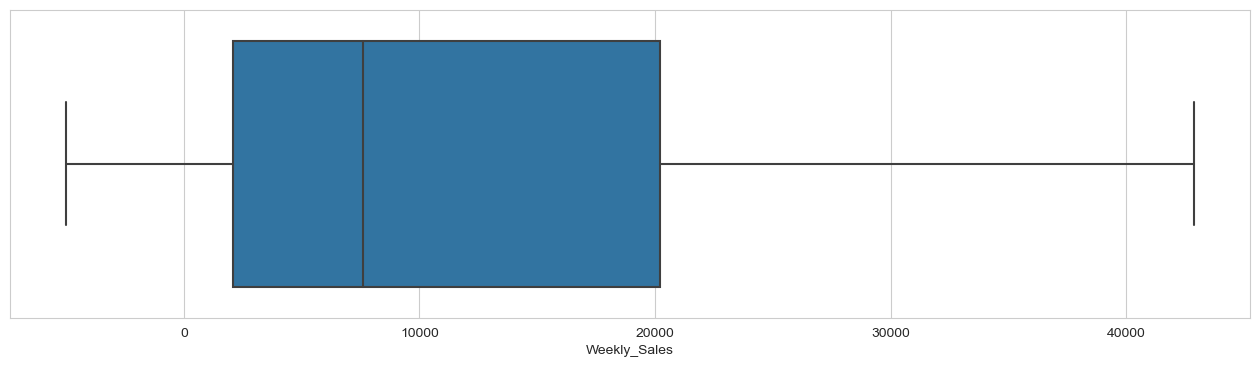

In [25]:
# Check outliners of Unemployment
plt.figure(figsize=(16, 4))
sns.boxplot(x=iqr_method_outliers(master_df['Weekly_Sales']))
plt.show()

In [26]:
master_df['Weekly_Sales'] = iqr_method_outliers(column=master_df['Weekly_Sales'])

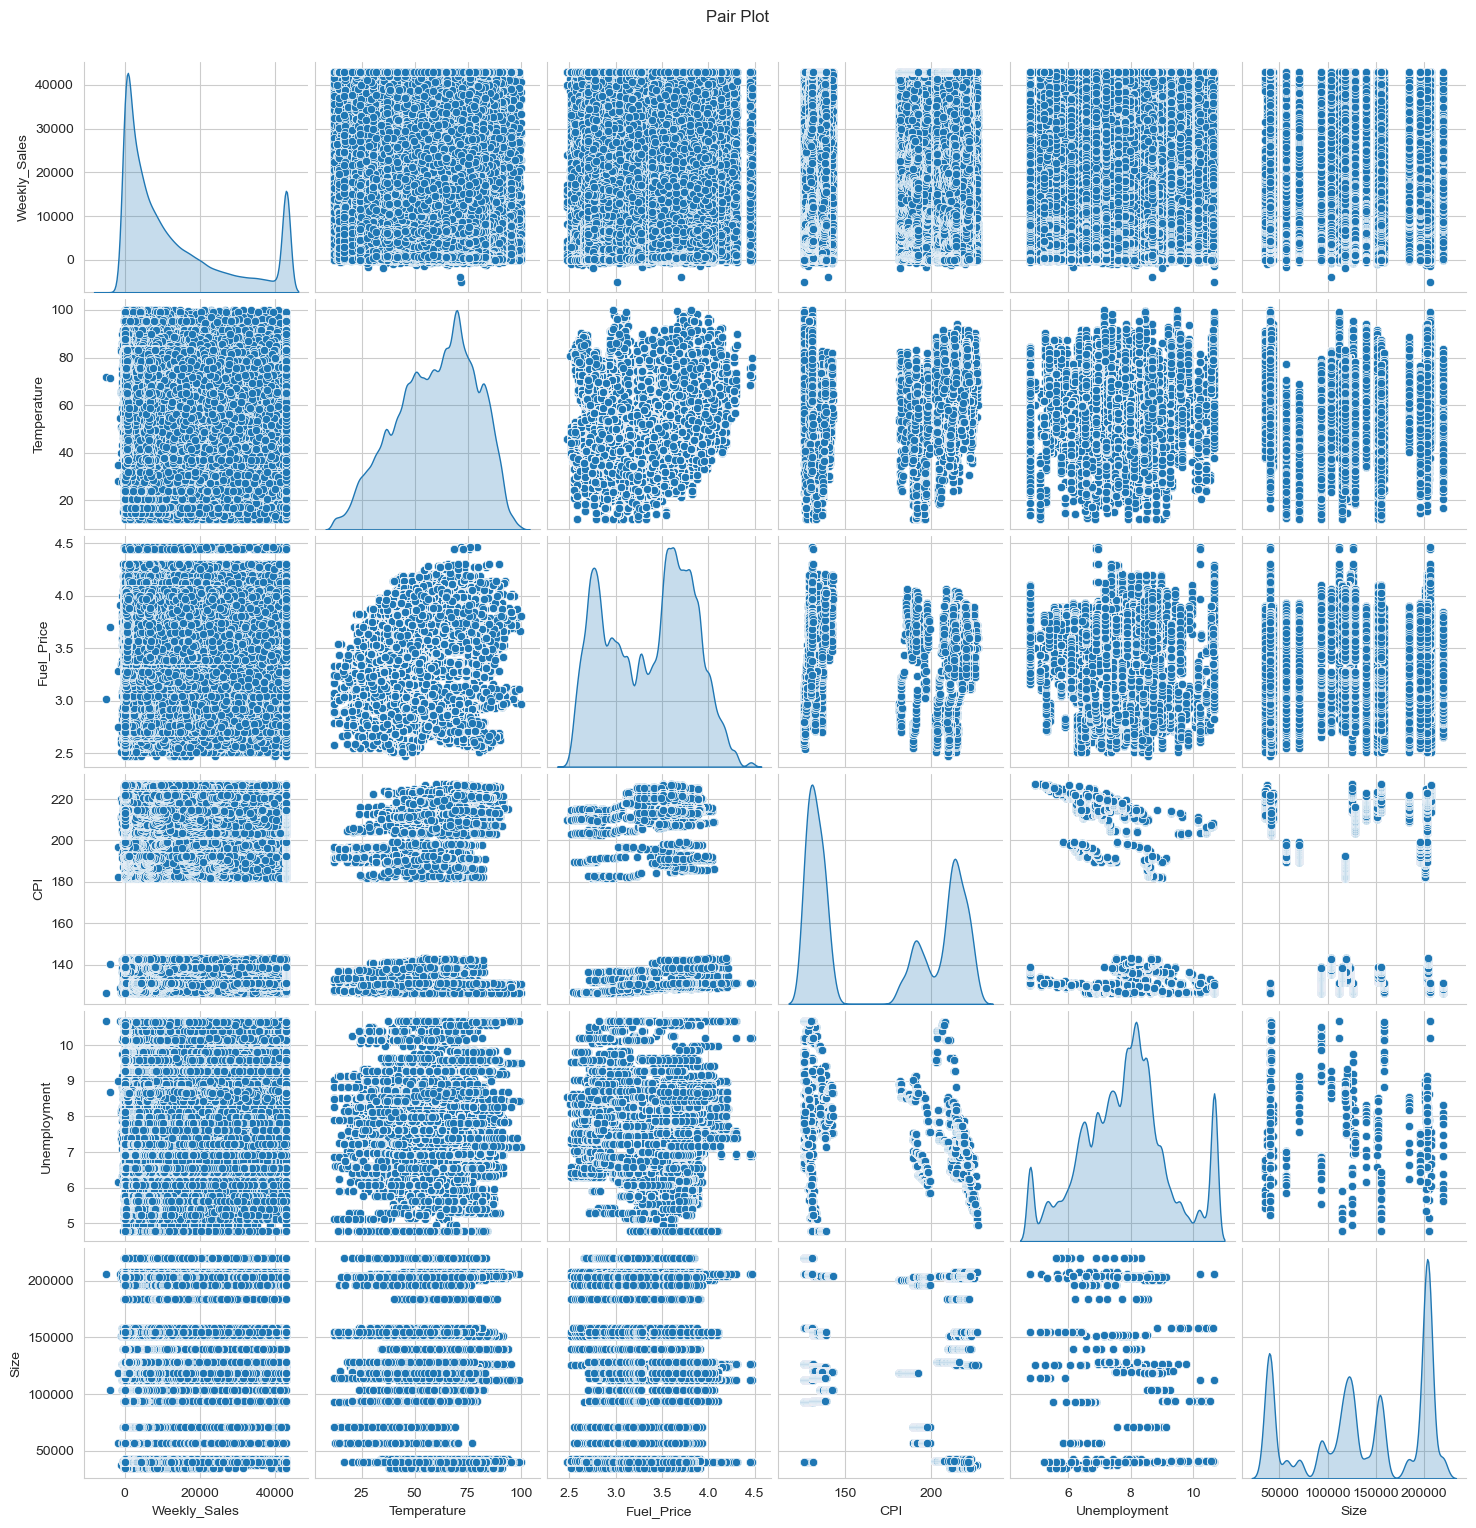

In [27]:
# Check for linearity using pair plot 
sns.pairplot(master_df[['Weekly_Sales','Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']], diag_kind="kde") 
plt.suptitle('Pair Plot', y=1.02) 
plt.show()

Strongest Correlation: The strongest relationship appears to be between Weekly Sales and Store Size, suggesting that larger stores tend to perform better in terms of sales.

Seasonal Effects: Temperature has some influence on sales, indicating possible seasonal trends.

Economic Indicators: CPI and Unemployment show weaker correlations but are still relevant indicators of sales trends.

Variable Influences: While Fuel Price doesn't show a strong direct correlation with weekly sales, it might still have an indirect impact when combined with other economic factors.

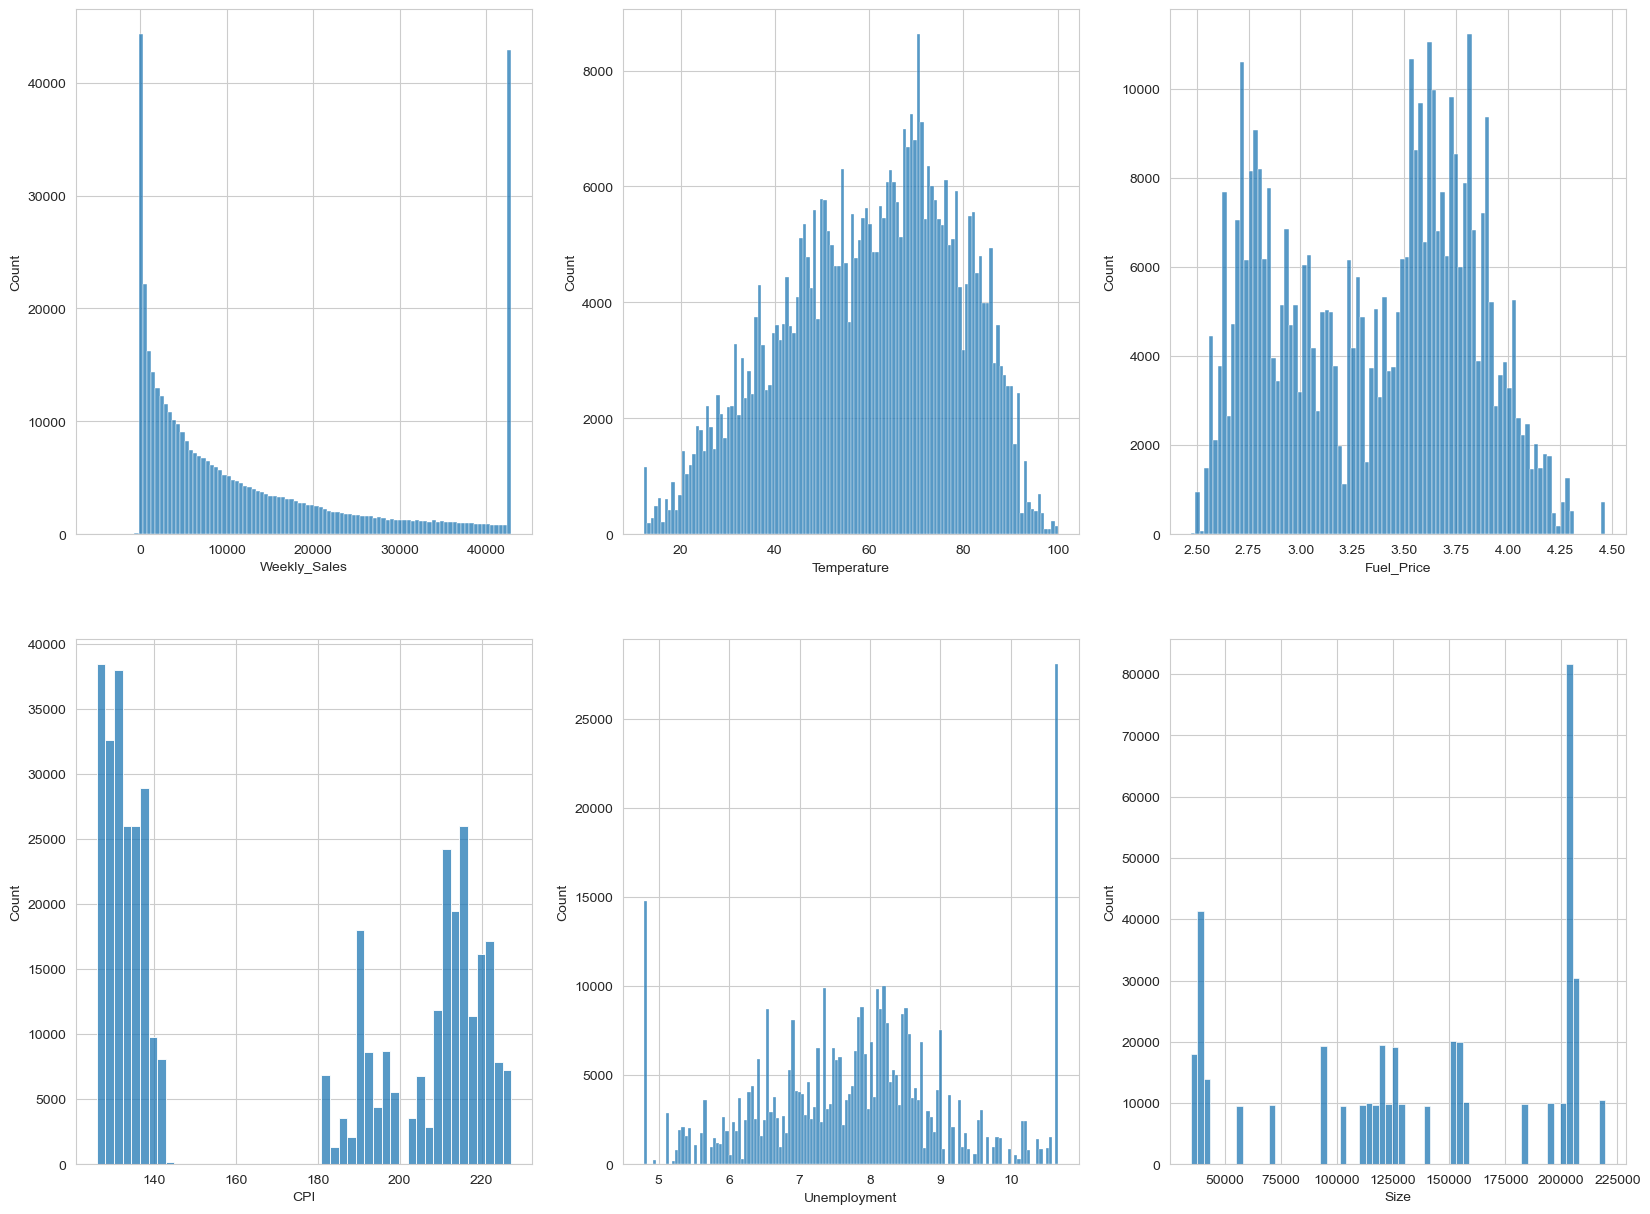

In [28]:
fig, ax = plt.subplots(2,3, figsize = (20,15))

for i, col in enumerate(master_df[['Weekly_Sales','Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']]):
    sns.histplot(x = col,
                   data = master_df,
                   ax = ax[i//3, i%3])

plt.show()

Let us Jarque-Bera test to check the normality of the target variable.

The null and alternate hypothesis of Jarque-Bera test are as follows:

H0: The data is normally distributed\
H1: The data is not normally distributed

In [29]:
from scipy.stats import jarque_bera
# List of features to test 
features_to_test = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size'] 
# Perform Jarque-Bera test and store results 
alpha = 0.05
jb_results = {} 
for feature in features_to_test: 
    stat, p = jarque_bera(master_df[feature]) 
    jb_results[feature] = {'Jarque-Bera Statistic': stat, 'p-value': p, "Reject": p<alpha} 
# Display the results 
jb_results_df = pd.DataFrame(jb_results).T 
print(jb_results_df)

             Jarque-Bera Statistic p-value Reject
Weekly_Sales          78367.461532     0.0   True
Temperature           14616.607013     0.0   True
Fuel_Price            25455.823472     0.0   True
CPI                   59316.241408     0.0   True
Unemployment            925.107919     0.0   True
Size                  33022.623509     0.0   True


p-value is less than the chosen significance level 0.05, we reject the null hypothesis, suggesting that the data does not follow a normal distribution.

Given that none of these features are normally distributed, consider scaling the data.

# MACHINE LEARNING

# 5.Feature Engineering

As we have dates in our dataset, we can build DateTime features using pandas.

In [30]:
#The day of the week with Monday=0, Sunday=6.
master_df['Day_of_week'] =master_df['Date'].dt.dayofweek

#The month as January=1, December=12.
master_df['Month'] =master_df['Date'].dt.month 

#The year of the datetime.
master_df['Year'] =master_df['Date'].dt.year

#The days of the datetime.
master_df['Day'] =master_df['Date'].dt.day 

In [31]:
# Impute NULL values
master_df['MarkDown1'] = master_df['MarkDown1'].fillna(0)
master_df['MarkDown2'] = master_df['MarkDown2'].fillna(0)
master_df['MarkDown3'] = master_df['MarkDown3'].fillna(0)
master_df['MarkDown4'] = master_df['MarkDown4'].fillna(0)
master_df['MarkDown5'] = master_df['MarkDown5'].fillna(0)

In [32]:
#Encode categorical variables
cols_to_encode = ['Type', 'IsHoliday']
master_df = pd.get_dummies(data = master_df, columns = cols_to_encode, dtype='int')

In [33]:
master_df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Day_of_week,Month,Year,Day,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
0,1,1,2010-02-05,24924.500000,42.31,2.572,0.0,0.0,0.0,0.0,...,151315,4,2,2010,5,1,0,0,1,0
1,1,1,2010-02-12,42863.605625,38.51,2.548,0.0,0.0,0.0,0.0,...,151315,4,2,2010,12,1,0,0,0,1
2,1,1,2010-02-19,41595.550000,39.93,2.514,0.0,0.0,0.0,0.0,...,151315,4,2,2010,19,1,0,0,1,0
3,1,1,2010-02-26,19403.540000,46.63,2.561,0.0,0.0,0.0,0.0,...,151315,4,2,2010,26,1,0,0,1,0
4,1,1,2010-03-05,21827.900000,46.50,2.625,0.0,0.0,0.0,0.0,...,151315,4,3,2010,5,1,0,0,1,0


In [34]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Store            421570 non-null  int64         
 1   Dept             421570 non-null  int64         
 2   Date             421570 non-null  datetime64[ns]
 3   Weekly_Sales     421570 non-null  float64       
 4   Temperature      421570 non-null  float64       
 5   Fuel_Price       421570 non-null  float64       
 6   MarkDown1        421570 non-null  float64       
 7   MarkDown2        421570 non-null  float64       
 8   MarkDown3        421570 non-null  float64       
 9   MarkDown4        421570 non-null  float64       
 10  MarkDown5        421570 non-null  float64       
 11  CPI              421570 non-null  float64       
 12  Unemployment     421570 non-null  float64       
 13  Size             421570 non-null  int64         
 14  Day_of_week      421

**Are there any notable correlation between variables**

Correlation is a bivariate analysis that measures the strength of association between two variables and the direction of the relationship. In terms of the strength of the relationship, the value of the correlation coefficient varies between +1 and -1.

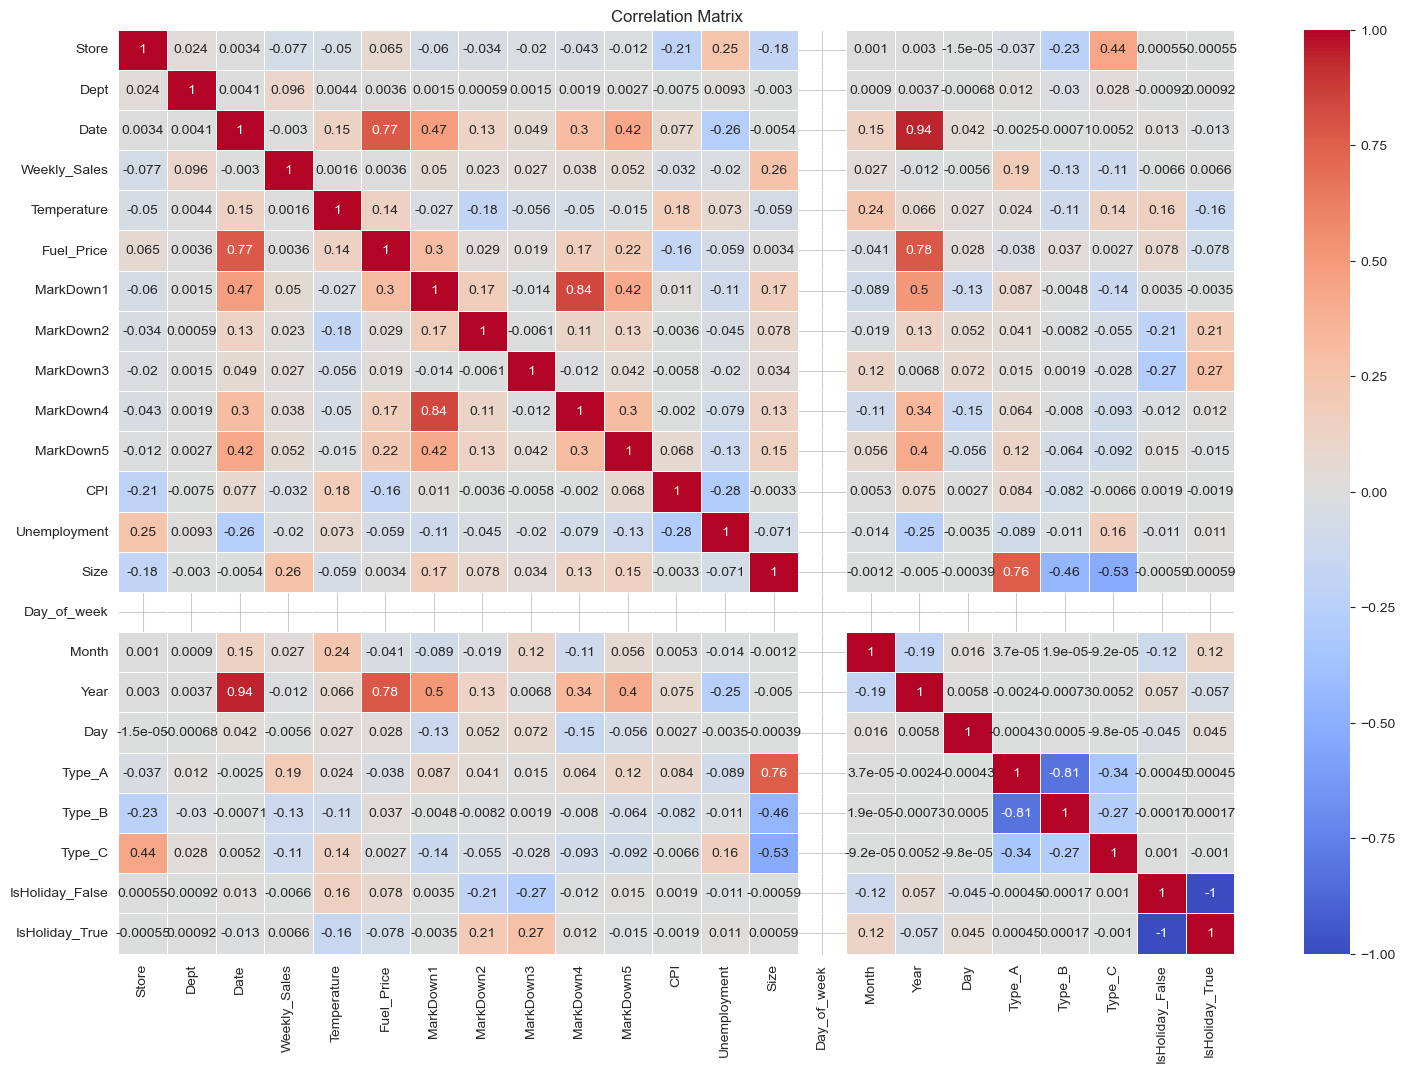

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Day_of_week,Month,Year,Day,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
Store,1.000000,0.024004,0.003362,-0.076513,-0.050423,0.065290,-0.059844,-0.033829,-0.020331,-0.042724,...,-0.182881,NaN,0.001011,0.002997,-0.000015,-0.037119,-0.233461,0.439004,0.000548,-0.000548
Dept,0.024004,1.000000,0.004054,0.095734,0.004437,0.003572,0.001494,0.000587,0.001475,0.001937,...,-0.002966,NaN,0.000904,0.003738,-0.000678,0.012134,-0.029968,0.028324,-0.000916,0.000916
Date,0.003362,0.004054,1.000000,-0.003050,0.147040,0.771913,0.470865,0.127975,0.048749,0.297472,...,-0.005437,NaN,0.146422,0.941467,0.041757,-0.002467,-0.000714,0.005245,0.013017,-0.013017
Weekly_Sales,-0.076513,0.095734,-0.003050,1.000000,0.001632,0.003594,0.050339,0.022758,0.026615,0.038418,...,0.263892,NaN,0.026949,-0.011986,-0.005639,0.189970,-0.125087,-0.112854,-0.006579,0.006579
Temperature,-0.050423,0.004437,0.147040,0.001632,1.000000,0.143717,-0.026608,-0.179919,-0.056132,-0.050461,...,-0.058675,NaN,0.235625,0.065916,0.026684,0.024302,-0.108849,0.135669,0.156193,-0.156193
Fuel_Price,0.065290,0.003572,0.771913,0.003594,0.143717,1.000000,0.297056,0.029153,0.018615,0.166622,...,0.003361,NaN,-0.040876,0.779633,0.028058,-0.037973,0.037317,0.002652,0.078281,-0.078281
MarkDown1,-0.059844,0.001494,0.470865,0.050339,-0.026608,0.297056,1.000000,0.174868,-0.014411,0.838904,...,0.169788,NaN,-0.089206,0.501044,-0.126187,0.086555,-0.004814,-0.135776,0.003521,-0.003521
MarkDown2,-0.033829,0.000587,0.127975,0.022758,-0.179919,0.029153,0.174868,1.000000,-0.006080,0.113250,...,0.078372,NaN,-0.019360,0.131867,0.051971,0.040873,-0.008214,-0.054511,-0.207604,0.207604
MarkDown3,-0.020331,0.001475,0.048749,0.026615,-0.056132,0.018615,-0.014411,-0.006080,1.000000,-0.012020,...,0.033641,NaN,0.116031,0.006789,0.072156,0.015083,0.001890,-0.028072,-0.266471,0.266471
MarkDown4,-0.042724,0.001937,0.297472,0.038418,-0.050461,0.166622,0.838904,0.113250,-0.012020,1.000000,...,0.127334,NaN,-0.105569,0.335340,-0.152753,0.063737,-0.008012,-0.092760,-0.011565,0.011565


In [35]:
# find correlation matrix for features
correlation_matrix = master_df.corr()

# Creating a heatmap for the correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

correlation_matrix

weekly sales have the highest correlation of 0.24 with the size of the store, which is in line with our previous findings.MarkDown1 has a correlation of 0.84 with Markdown2.
Date is Highly correlated with Year (0.94). Using the extracted components like Year, Month, and Day makes the Date column redundant.\
Type A is highly correlated with size, Type_B and Type_C are moderately correlated with Store Size (-0.46 and -0.53, respectively). Including these might introduce redundancy as Size already encapsulates store type characteristics.

# Feature Selection

In [36]:
#Make Copy of the dataset
df_copy = master_df.copy()
df_copy.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Size,Day_of_week,Month,Year,Day,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
0,1,1,2010-02-05,24924.500000,42.31,2.572,0.0,0.0,0.0,0.0,...,151315,4,2,2010,5,1,0,0,1,0
1,1,1,2010-02-12,42863.605625,38.51,2.548,0.0,0.0,0.0,0.0,...,151315,4,2,2010,12,1,0,0,0,1
2,1,1,2010-02-19,41595.550000,39.93,2.514,0.0,0.0,0.0,0.0,...,151315,4,2,2010,19,1,0,0,1,0
3,1,1,2010-02-26,19403.540000,46.63,2.561,0.0,0.0,0.0,0.0,...,151315,4,2,2010,26,1,0,0,1,0
4,1,1,2010-03-05,21827.900000,46.50,2.625,0.0,0.0,0.0,0.0,...,151315,4,3,2010,5,1,0,0,1,0


In [37]:
#Drop redundant Features
features_drop = ['Date','Day_of_week','Type_A','Type_B','Type_C','IsHoliday_False']
selected_features = df_copy.drop(features_drop, axis=1)

In [38]:
selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           421570 non-null  int64  
 1   Dept            421570 non-null  int64  
 2   Weekly_Sales    421570 non-null  float64
 3   Temperature     421570 non-null  float64
 4   Fuel_Price      421570 non-null  float64
 5   MarkDown1       421570 non-null  float64
 6   MarkDown2       421570 non-null  float64
 7   MarkDown3       421570 non-null  float64
 8   MarkDown4       421570 non-null  float64
 9   MarkDown5       421570 non-null  float64
 10  CPI             421570 non-null  float64
 11  Unemployment    421570 non-null  float64
 12  Size            421570 non-null  int64  
 13  Month           421570 non-null  int32  
 14  Year            421570 non-null  int32  
 15  Day             421570 non-null  int32  
 16  IsHoliday_True  421570 non-null  int32  
dtypes: float64

In [39]:
# Initialize the scaler 
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(selected_features)

# Convert the scaled data back to a DataFrame 
scaled_df = pd.DataFrame(scaled_data, columns=selected_features.columns)
print(scaled_df.describe().T)

                   count          mean       std       min       25%  \
Store           421570.0 -7.335157e-17  1.000001 -1.658199 -0.876050   
Dept            421570.0 -3.775448e-17  1.000001 -1.418742 -0.861219   
Weekly_Sales    421570.0 -1.059822e-16  1.000001 -1.301750 -0.796787   
Temperature     421570.0  1.000089e-15  1.000001 -2.600660 -0.728243   
Fuel_Price      421570.0 -1.038248e-17  1.000001 -1.938930 -0.933508   
MarkDown1       421570.0 -2.642814e-17  1.000001 -0.427943 -0.427943   
MarkDown2       421570.0 -3.397903e-17  1.000001 -0.225337 -0.173069   
MarkDown3       421570.0 -2.029303e-17  1.000001 -0.089926 -0.084662   
MarkDown4       421570.0  9.843133e-18  1.000001 -0.278117 -0.278117   
MarkDown5       421570.0 -7.004805e-17  1.000001 -0.395181 -0.395181   
CPI             421570.0 -5.042920e-16  1.000001 -1.152677 -1.000512   
Unemployment    421570.0 -1.215694e-15  1.000001 -2.132200 -0.652536   
Size            421570.0  1.035552e-16  1.000001 -1.670254 -0.70

In [40]:
feature = selected_features.drop(columns=['Weekly_Sales'])
target = selected_features['Weekly_Sales']

# Train-Test Split

In [41]:
# add the intercept column to the dataset
x_constant = sm.add_constant(feature)

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x_constant, target, test_size=0.2, random_state=42)

In [42]:
# check the dimensions of the train & test subset

# print dimension of predictors train set
print("The shape of X_train is:",X_train.shape)

# print dimension of predictors test set
print("The shape of X_test is:",X_test.shape)

# print dimension of target train set
print("The shape of y_train is:",y_train.shape)

# print dimension of target test set
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (337256, 17)
The shape of X_test is: (84314, 17)
The shape of y_train is: (337256,)
The shape of y_test is: (84314,)


# Build Model Using OLS

In [43]:
# Build the model using OLS(Ordinary Least Square) 
lin_reg = sm.OLS(y_train, X_train).fit()

# print the summary output
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1900.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:26:20   Log-Likelihood:            -3.6838e+06
No. Observations:              337256   AIC:                         7.368e+06
Df Residuals:                  337239   BIC:                         7.368e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.209e+06   1.27e+05      9.

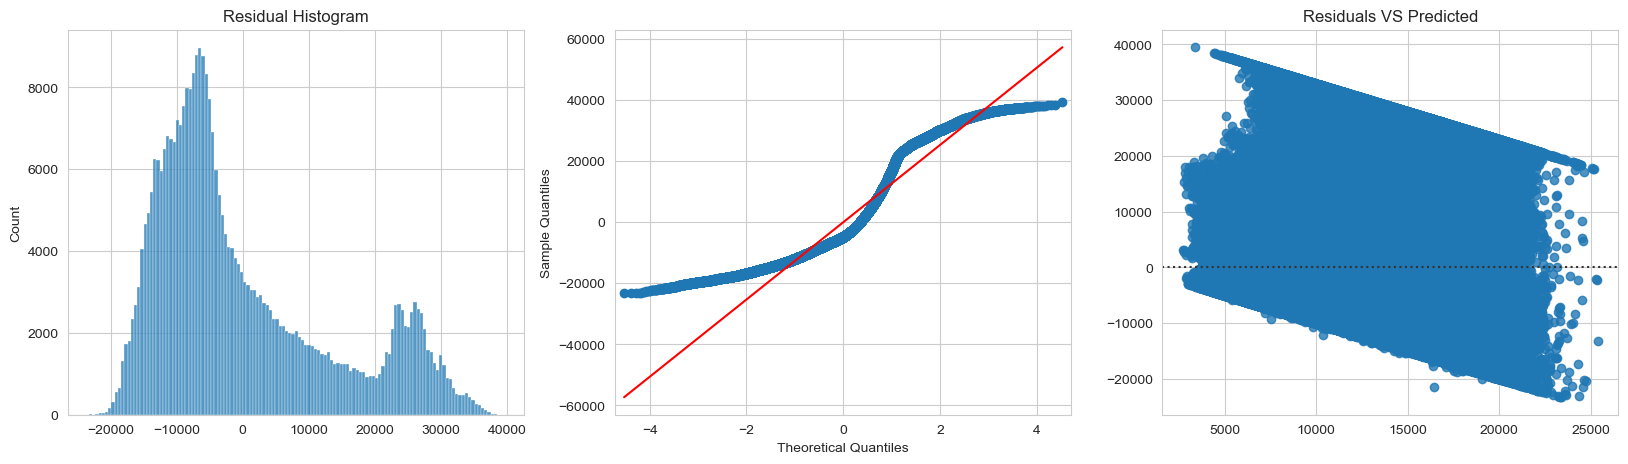

In [44]:
fig, ax = plt.subplots(1,3, figsize = (20,5))
sns.histplot(lin_reg.resid, ax = ax[0]).set_title('Residual Histogram')
sm.qqplot(lin_reg.resid,line = 'r', ax = ax[1])
sns.residplot(x=lin_reg.fittedvalues, y=lin_reg.resid, ax = ax[2]).set_title('Residuals VS Predicted')
plt.show()

Residual Histogram: The histogram of residuals indicates a skewed distribution, particularly with a large peak around -10000 and a smaller peak around 20000. This suggests that the residuals are not normally distributed, which can violate the assumptions of the linear regression model.

Q-Q Plot: The Q-Q plot shows a deviation from the red line, indicating that the residuals do not follow a normal distribution. This further confirms the skewness observed in the residual histogram.

Residuals vs. Predicted Values: The scatter plot of residuals against predicted values exhibits a funnel shape, indicating heteroscedasticity. This means that the variance of the residuals increases with the predicted values, suggesting that the model's prediction errors are not constant across all levels of predicted values.

The OLS regression results indicate that the model explains 8.3% of the variance in Weekly Sales, with significant predictors such as Store, Dept, Temperature, Fuel Price, several MarkDowns, CPI, Unemployment, Size, Month, Year, Day, and IsHoliday_True. Positive coefficients for Dept, Temperature, Fuel Price, certain MarkDowns, Size, Month, and IsHoliday_True suggest these factors increase sales, while negative coefficients for Store, CPI, Unemployment, Year, and Day suggest they decrease sales. The significant F-statistic confirms the model's overall fit, but the high condition number indicates potential multicollinearity issues that need addressing for better model stability and performance. Further improvements could involve feature engineering, alternative models, and robust standard errors to manage heteroscedasticity.

# Multicollinearity

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame() 
vif_data['Feature'] = x_constant.columns 
vif_data['VIF'] = [variance_inflation_factor(x_constant.values, i) for i in range(x_constant.shape[1])]

# Display the results 
print(vif_data)

           Feature           VIF
0            const  3.030710e+07
1            Store  1.146447e+00
2             Dept  1.000680e+00
3      Temperature  1.261023e+00
4       Fuel_Price  3.485300e+00
5        MarkDown1  4.490786e+00
6        MarkDown2  1.141265e+00
7        MarkDown3  1.104525e+00
8        MarkDown4  3.570000e+00
9        MarkDown5  1.394403e+00
10             CPI  1.331794e+00
11    Unemployment  1.293534e+00
12            Size  1.112535e+00
13           Month  1.264571e+00
14            Year  4.776293e+00
15             Day  1.042031e+00
16  IsHoliday_True  1.179406e+00


The Variance Inflation Factor (VIF) analysis indicates that there are no severe multicollinearity issues among the features, as all VIF values are well below the critical threshold of 10

Given these results, you can proceed with using these features in more advanced models like Random Forests, Gradient Boosting, or XGBoost to capture non-linear relationships and potentially improve predictive performance. These models can handle multicollinearity better and might provide a more accurate fit for our data.

# Build Model Using Random Forest Regression

In [ ]:
# Initialize and train the model 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 
rf_model.fit(X_train, y_train) 

# Predict and evaluate 
y_pred = rf_model.predict(X_test) 

In [47]:
#Calculate Mean Square Error
mse = mean_squared_error(y_test, y_pred) 
print(f'Mean Squared Error: {mse}')

# Calculate Root Mean Squared Error 
rmse = np.sqrt(mse) 
print(f"Root Mean Squared Error: {rmse}")

# Calculate R^2 Score 
r2 = r2_score(y_test, y_pred) 
print(f"R2 Score: {r2}")

Mean Squared Error: 3198705.1601620577
Root Mean Squared Error: 1788.4924266437522
R2 Score: 0.9836158281172659


These results indicate that the model explains approximately 98.36% of the variance in Weekly Sales, suggesting a high degree of accuracy. The low RMSE value indicates that the model's predictions are close to the actual values, providing confidence in its predictive capability. Overall, the Random Forest model is a significant improvement over the previous linear regression model and is likely to provide robust and reliable predictions for the data

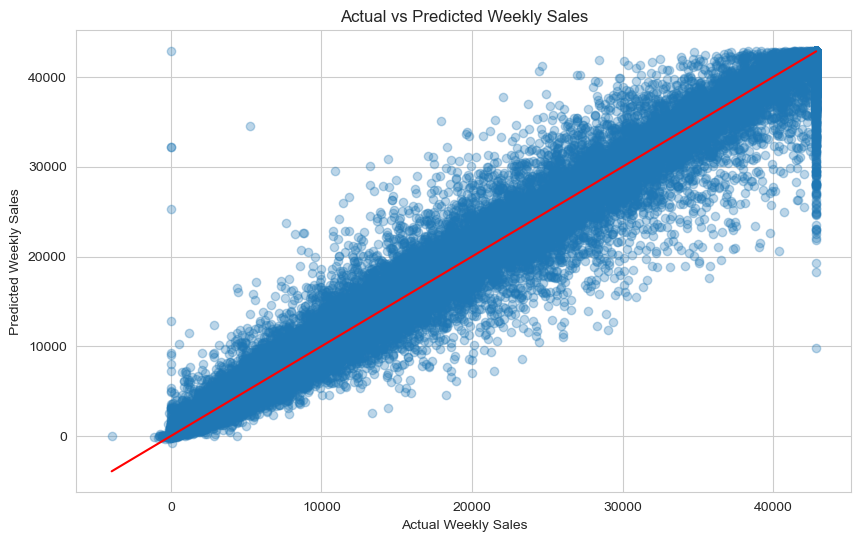

In [48]:
# scatter plot between observed and predicted values of weekly sales from Random Forest regressor
plt.figure(figsize=(10, 6)) 
plt.scatter(y_test, y_pred, alpha=0.3) 
plt.title('Actual vs Predicted Weekly Sales') 
plt.xlabel('Actual Weekly Sales') 
plt.ylabel('Predicted Weekly Sales') 
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line y=x for reference 
plt.show()

The scatter plot comparing actual weekly sales (y_test) to predicted values from the Random Forest model reveals a strong correlation, with most points closely aligned along the diagonal line, indicating high accuracy. This tight clustering suggests that the model consistently makes accurate predictions. Some deviations exist, pointing to potential outliers or less accurate predictions under specific conditions. Overall, the plot confirms the model's high performance.

# Feature Importance

Analyze the feature importance scores from the Random Forest model to understand which features are most influential in predicting sales.

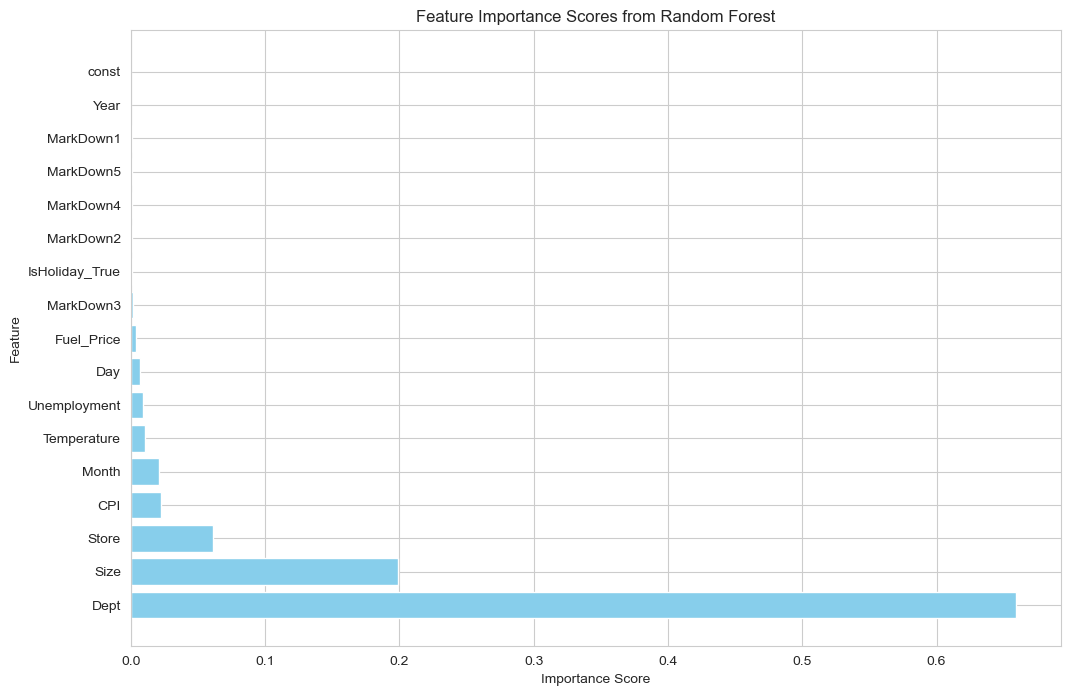

In [59]:
# Get feature importance scores 
feat_importance = rf_model.feature_importances_

# Create a DataFrame for better visualization 
feat_column = X_train.columns # Assuming X_train is a DataFrame 
importance_df = pd.DataFrame({'Feature': feat_column, 'Importance': feat_importance}) 

# Sort the DataFrame by importance scores 
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance scores 
plt.figure(figsize=(12, 8)) 
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue') 
plt.xlabel('Importance Score') 
plt.ylabel('Feature') 
plt.title('Feature Importance Scores from Random Forest') 
#plt.gca().invert_yaxis() 
plt.show()

Top Influential Features: \
Dept: With the highest importance score approx. 0.65, the department variable significantly impacts the prediction of weekly sales. This suggests that sales patterns vary considerably between different departments.

Size: The store size also plays a crucial role, with an importance score of approx. 0.25. Larger stores likely have higher sales, which aligns with expectations.

Store: The specific store location has an importance score of approx. 0.10, indicating that sales vary by store.

Less Influential Features:Features like Year, MarkDown1, MarkDown5, MarkDown4, MarkDown3, IsHoliday_True and MarkDown2, have very low importance scores close to zero. This implies that these variables have minimal impact on the sales prediction and could potentially be less prioritized in the model.

**Lets Build the model with the important features**

In [61]:
# Make list of important features
important_var = ['Dept','Size','Store','CPI','Temperature','Unemployment','Day','Fuel_Price'] 

# Creating a new dataframe with only the important features
X_imp = selected_features[important_var] 
y = selected_features['Weekly_Sales'] 

# Split the data into training and test sets 
X_train_imp, X_test_imp, y_train, y_test = train_test_split(X_imp, y, test_size=0.2, random_state=42) 

# Define and train the model 
rf_model_imp = RandomForestRegressor(n_estimators=100, random_state=42) 
rf_model_imp.fit(X_train_imp, y_train)

# Predict and evaluate 
y_pred_imp = rf_model_imp.predict(X_test_imp) 

# Calculate Mean Squared Error,Root Mean Squared Error, and R² Score 
mse_imp = mean_squared_error(y_test, y_pred_imp) 
rmse_imp = np.sqrt(mse_imp) 
r2_imp = r2_score(y_test, y_pred_imp)

In [62]:
# Print the result with important features
print(f"Mean Squared Error: {mse_imp}") 
print(f"Root Mean Squared Error: {rmse_imp}") 
print(f"R² Score: {r2_imp}")

Mean Squared Error: 5988396.650878752
Root Mean Squared Error: 2447.1200728363847
R² Score: 0.969326675915008


The Mean Squared Error (MSE) of the Random Forest model has increased to approximately 5,988,396.65, indicating that the model's predictions are somewhat less accurate compared to using the full set of features. The Root Mean Squared Error (RMSE) is around 2,447.12, which is higher than the previous RMSE, suggesting an increase in the average prediction error. The R² score, while still high at 0.9693, is slightly lower than the full feature model's R² score of 0.9836, meaning the model with only the important features explains about 96.93% of the variance in the data, compared to 98.36% with all features.

# Build Model Using Decision Tree Regression

In [68]:
# Define and train the model 
decision_tree_reg = DecisionTreeRegressor(random_state = 42)
decision_tree_reg.fit(X_train, y_train)

# Predict and evaluate 
y_pred_dtreg = decision_tree_reg.predict(X_test)

In [70]:
# Calculate Mean Squared Error,Root Mean Squared Error, and R2 Score 
mse_dtreg = mean_squared_error(y_test, y_pred_dtreg) 
rmse_dtreg = np.sqrt(mse_dtreg) 
r2_dtreg = r2_score(y_test, y_pred_dtreg)

In [71]:
# Print the result with important features
print(f"Mean Squared Error: {mse_dtreg}") 
print(f"Root Mean Squared Error: {rmse_dtreg}") 
print(f"R² Score: {r2_dtreg}")

Mean Squared Error: 5730328.747477921
Root Mean Squared Error: 2393.8105078468348
R² Score: 0.970648532314715


The R2 score of 0.9706 is slightly lower than the full feature Random Forest model (0.9836) but higher than the Random Forest model with important features (0.9693). This means the Decision Tree Regressor explains about 97.06% of the variance in the data

# Build Model Using XGBoost Regressor

Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

In [74]:
# Define and train the model 
xgb_reg = XGBRegressor(objective = 'reg:linear', random_state = 42)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate 
y_pred_xgb = xgb_reg.predict(X_test)

In [75]:
# Calculate Mean Squared Error, Root Mean Squared Error, and R2 Score
mse_xgb = mean_squared_error(y_test, y_pred_xgb) 
rmse_xgb = np.sqrt(mse_xgb) 
r2_xgb = r2_score(y_test, y_pred_xgb)

In [76]:
print(f"Mean Squared Error: {mse_xgb}") 
print(f"Root Mean Squared Error: {rmse_xgb}") 
print(f"R2 Score: {r2_xgb}")

Mean Squared Error: 9851820.108685024
Root Mean Squared Error: 3138.760919325495
R2 Score: 0.949537732946198


The R2 score of 0.9495 is lower than the full feature Random Forest model (0.9836), Decision Tree Regression (0.9706) and Random Forest model with important features (0.9693). This means the XGBoost explains about 9.95% of the variance in the data

**Hyper Parameter Tuning**

In [77]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='r2', verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best R² Score from Grid Search: {best_score}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best R² Score from Grid Search: 0.9676928063967303


With Hyper tuning XGBoost has R2 score of 0.9677, Which less than Random Forest Regression Model

**Out of Xgboost, Decision tree and Random Forest, full random Forest Regression gives the best result**

Lets Do the Residual Analysis for Random Forest Regression Model

**Residual Analysis**

Perform residual analysis for Random Forest Regression Model

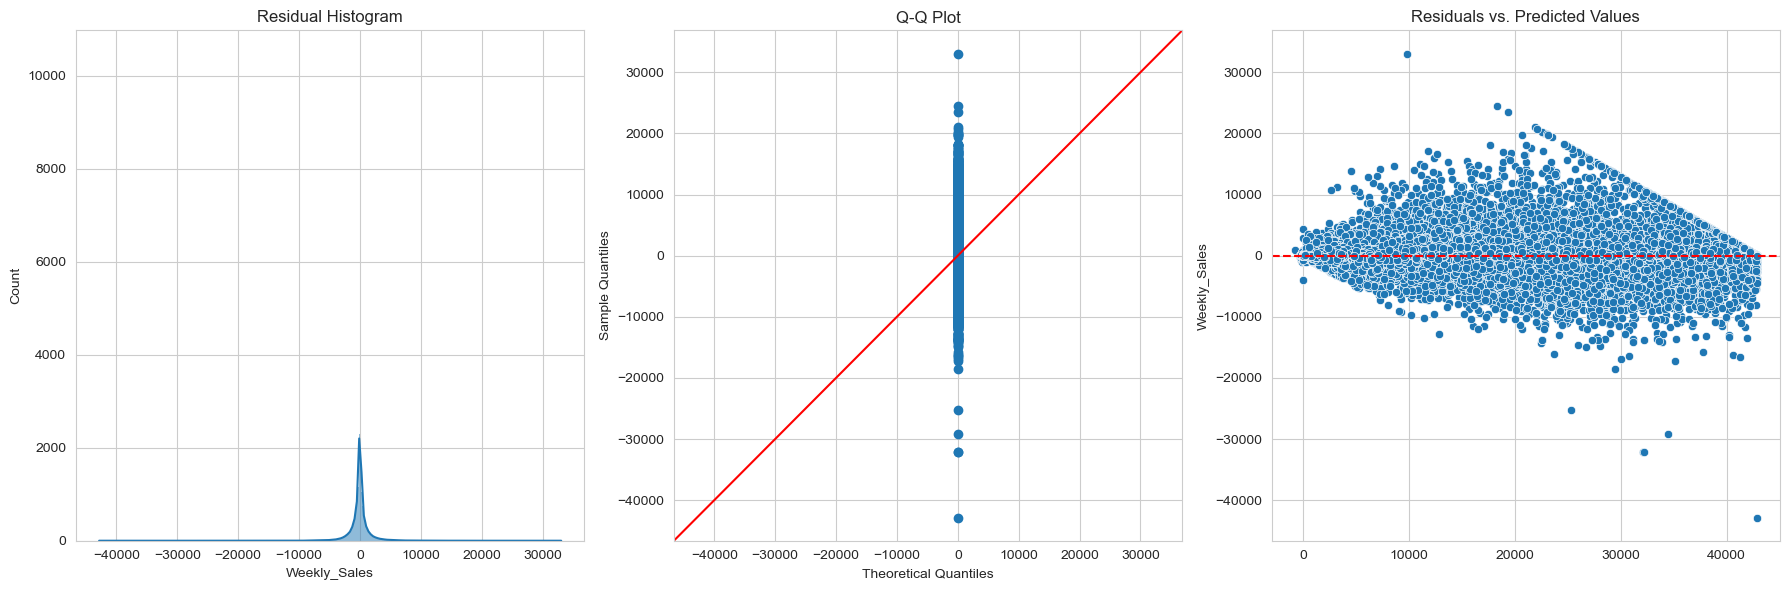

In [49]:
# Compute residuals 
residuals = y_test - y_pred 

# Create subplots 
fig, ax = plt.subplots(1, 3, figsize=(18, 6)) 

# Residual Histogram 
sns.histplot(residuals, kde=True, ax=ax[0]).set_title('Residual Histogram') 

# Q-Q Plot 
sm.qqplot(residuals, line='45', ax=ax[1]) 
ax[1].set_title('Q-Q Plot') 

# Residuals vs. Predicted Values 
sns.scatterplot(x=y_pred, y=residuals, ax=ax[2]) 
ax[2].set_title('Residuals vs. Predicted Values') 
ax[2].axhline(0, color='red', linestyle='--') 
plt.tight_layout()
plt.show()

Residual Histogram: The histogram is highly peaked around zero, indicating that most residuals are close to zero, suggesting that the model's predictions are generally accurate. However, there are some extreme values on both sides, pointing to the presence of outliers or less accurate predictions in some cases.

Q-Q Plot:The residuals deviate significantly from the line of perfect normality, especially at the tails. This suggests that the residuals are not normally distributed, which could indicate issues with model assumptions or the need for transformation of variables.

Residuals vs. Predicted Values:The funnel shape of the residuals indicates heteroscedasticity (non-constant variance of residuals). This means that the prediction errors vary at different levels of predicted values, which can affect the reliability of the model's predictions.

# Model Validation

Let's perform the K-Fold cross-validation to evaluate the model performance for Random Forest Regression Model.

In K-fold validation, the input data is divided into 'K' number of folds, hence the name K Fold. The model undergoes training with K-1 folds and is evaluated on the remaining fold. This procedure is performed K times, where each fold is utilized as the testing set one time. The performance metrics are averaged across K iterations to offer a more reliable evaluation of the model's performance

In [56]:
# Perform 5-fold cross-validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

# 5-fold cross-validation 
kf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')

In [57]:
print('The scores : ',kf_scores)
print('The mean score : ',np.mean(kf_scores))
print('The Std score : ',np.std(kf_scores))

The scores :  [0.98155098 0.98162959 0.98162219 0.98192901 0.98141049]
The mean score :  0.9816284536500204
The Std score :  0.0001696382225204708


The cross-validation scores are very consistent across the different folds, with a mean score of approximately 0.9816. This consistency suggests that the Random Forest model performs reliably across different subsets of the data.\
The high mean score indicates that the model explains approximately 98.16% of the variance in the data, which is an excellent performance for a regression model.\
The standard deviation is very low, indicating that there is minimal variation in the model's performance across the different folds

**Save The predicted values in a file**

In [50]:
# Create a DataFrame with actual and predicted values 
results_df = pd.DataFrame({ 'Actual': y_test, 
                           'Predicted': y_pred })

# Save the results to a CSV file 
results_df.to_csv('sale_predicted_results.csv', index=False) 

print("Predicted data has been saved to 'predicted_results.csv'")

Predicted data has been saved to 'predicted_results.csv'


# Conclusion

The sales prediction project successfully leveraged various regression models, including Random Forest, Decision Tree, and XGBoost, to forecast weekly sales. Among these, the Random Forest Regression model achieved an excellent R2 score of 0.9836, explaining 98.36% of the variance in the data. The analysis of feature importance identified Dept, Size, and Store as the most influential features. The model evaluation highlighted areas for improvement, such as addressing outliers and heteroscedasticity. The project concludes with a plan for continuous monitoring, and refining features to enhance predictive accuracy.

By applying these insights and refining the models, the sales prediction framework can provide reliable and actionable forecasts, aiding in strategic decision-making and operational efficiency.

​